In [1]:
import os
import getpass
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt.tool_executor import ToolExecutor
from langchain_core.agents import AgentAction, AgentFinish
from IPython.display import Image
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from langgraph.graph import END, StateGraph


In [2]:
def initialize_llm(**kwargs):
    # initialize llm
    llm = AzureChatOpenAI(
        deployment_name=os.environ["AZURE_OPENAI_DEPLOYMENT"],
        api_key=os.environ["AZURE_OPENAI_API_KEY"],
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        api_version=os.environ["AZURE_OPENAI_API_VERSION"],
        **kwargs
    )
    return llm

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
llm = initialize_llm(temperature=0.5, streaming=True)
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)
tools = [tavily_tool]
tool_executor = ToolExecutor(tools=tools)

In [5]:
from langchain.tools.render import format_tool_to_openai_function
functions = [format_tool_to_openai_function(tool) for tool in tools]
llm_with_tools = llm.bind_functions(functions)

/Users/swapnilagashe/personal/Upskilling/AI/Langchain/llm_tree_search/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.2.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


In [6]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],operator.add]
    

### define nodes

In [7]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage

In [8]:
def should_continue(state):
    messages = state['messages']
    last_message = messages[-1]
    if "function_call" not in last_message.additional_kwargs:
        return "end"
    else:
        return "continue"

def call_model(state):
    messages = state['messages']
    response =llm_with_tools.invoke(messages)
    # we return a list that will get added to the existing list
    return {"messages":[response]}



In [10]:
def call_tool(state):
    messages = state['messages']
    last_message = messages[-1]
    
    action = ToolInvocation(
        tool = last_message.additional_kwargs["function_call"]["name"],
        tool_input = json.loads(last_message.additional_kwargs["function_call"]["arguments"]),
    )
    
    response = input(prompt=f"[y/n] continue with {action}?")
    if response=='n':
        raise ValueError
    
    # we call the tool executor and get back a response
    response  = tool_executor.invoke(action)
    
    # use the response to create a function message
    function_message = FunctionMessage(content = str(response), name = action.tool)
    
    # we return a list that will get added to the existing list
    return {"messages":[function_message]}

In [11]:
workflow = StateGraph(AgentState)

# create nodes
workflow.add_node("agent",call_model)
workflow.add_node("action",call_tool)

workflow.set_entry_point("agent")

# add conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"continue":"action",
    "end":END
    }
)

# add a normal edge
# because we always want to go to the agent after going to the action
workflow.add_edge("action","agent")

app = workflow.compile()

In [12]:
app.get_graph().print_ascii()


               +-----------+            
               | __start__ |            
               +-----------+            
                      *                 
                      *                 
                      *                 
                 +-------+              
                 | agent |              
                 +-------+*             
               ***         ***          
              *               *         
            **                 ***      
+-----------------+               *     
| should_continue |               *     
+-----------------+*              *     
          *         *****         *     
          *              ***      *     
          *                 ***   *     
    +---------+             +--------+  
    | __end__ |             | action |  
    +---------+             +--------+  


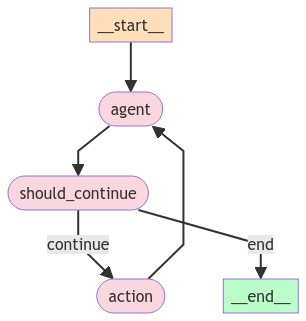

In [13]:
Image(app.get_graph().draw_mermaid_png(
    draw_method=MermaidDrawMethod.API,
))

In [14]:
from langchain_core.messages import HumanMessage
inputs  = {"messages":[HumanMessage(content="what is the weather in sf")]}
for output in app.stream(inputs):
    for key,value in output.items():
        print(f"output from node {key}")
        print("--------------------------------")
        print(value)
        print("--------------------------------")

output from node agent
--------------------------------
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "query": "weather in San Francisco"\n}', 'name': 'tavily_search_results_json'}}, response_metadata={'finish_reason': 'function_call'}, id='run-5baaa2ce-1029-4a60-a704-9326cc3275b1-0')]}
--------------------------------
output from node action
--------------------------------
{'messages': [FunctionMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1713645576, \'localtime\': \'2024-04-20 13:39\'}, \'current\': {\'last_updated_epoch\': 1713645000, \'last_updated\': \'2024-04-20 13:30\', \'temp_c\': 17.2, \'temp_f\': 63.0, \'is_day\': 1, \'condition\': {\'text\': \'Partly cloudy\', \'icon\': \'//cdn.weatherapi.com/wea

In [15]:
from langchain_core.messages import HumanMessage
inputs  = {"messages":[HumanMessage(content="what is the weather in sf")]}
for output in app.stream(inputs):
    for key,value in output.items():
        print(f"output from node {key}")
        print("--------------------------------")
        print(value)
        print("--------------------------------")

output from node agent
--------------------------------
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "query": "weather in San Francisco"\n}', 'name': 'tavily_search_results_json'}}, response_metadata={'finish_reason': 'function_call'}, id='run-86578674-03d9-4e71-8322-77638383947a-0')]}
--------------------------------


ValueError: 